# Reward design and testing

In [44]:
# Import relevant libraries

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('Romain/')

from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.persistence import RailEnvPersister
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from Romain import test_utils, training
from Romain.observation_utils import normalize_observation
from Romain.models import *
from Romain.deep_model_policy import DeepPolicy, PolicyParameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reward design

In [2]:
# Must modify two functions in env
#env.update_step_rewards
#env._handle_end_reward

## Testing

In [83]:
# Create the environment

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, 
    obs_builder_object=TreeObsForRailEnv(max_depth=3),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

_,_ = env.reset()

In [84]:
# Train this environment

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)
observation_tree_depth = 3
observation_radius = 10
observation_max_path_depth = 20

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size)
policy = DeepPolicy(model, policy_params)

In [85]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.995,
    "n_episodes": 1200,
    "checkpoint_interval": 50,
    "n_eval_episodes": 30,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

In [22]:
training.train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 0/100000 experiences

🚉 Training 2 trains on 20x15 grid for 1200 episodes, evaluating on 10 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.632 Avg: -0.996	 💯 Done: 50.00% Avg: 0.50%	 🎲 Epsilon: 0.995 	 🔀 Action Probs: ↻ 0.250 ← 0.188 ↑ 0.188 → 0.172 ◼ 0.203  	✅ Eval: score -0.574 done 0.0%
	🔍 Evaluation score: -0.574 done: 0.0%
🚂 Episode 50	 🏆 Score: -0.726 Avg: -0.817	 💯 Done: 0.00% Avg: 10.69%	 🎲 Epsilon: 0.774 	 🔀 Action Probs: ↻ 0.314 ← 0.186 ↑ 0.157 → 0.129 ◼ 0.214   	✅ Eval: score -0.597 done 5.0%
	🔍 Evaluation score: -0.597 done: 5.0%
🚂 Episode 100	 🏆 Score: -0.970 Avg: -0.724	 💯 Done: 0.00% Avg: 17.31%	 🎲 Epsilon: 0.603 	 🔀 Action Probs: ↻ 0.094 ← 0.109 ↑ 0.562 → 0.141 ◼ 0.094   	✅ Eval: score -0.497 done 35.0%
	🔍 Evaluation score: -0.497 done: 35.0%
🚂 Episode 150	 🏆 Score: -1.015 Avg: -0.655	 💯 Done: 0.00% Avg: 16.80%	 🎲 Epsilon: 0.469 	 🔀 Action Probs: ↻ 0.063 ← 0.683 ↑ 0.079 → 0.079 ◼ 0.095   	✅ Eval: score -0.581 done 5.0%
	🔍 Evaluation score

In [86]:
policy.load('checkpoints/checkpoint_1150.pth')

In [87]:
# Test the policy
n_test = 100

scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

	✅ Eval: score -0.227 done 57.5%


In [92]:
# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

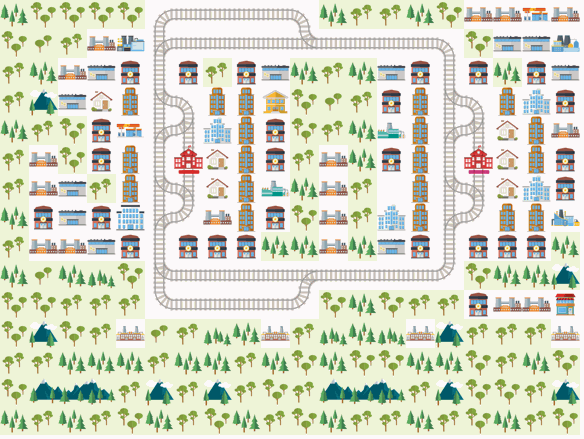

In [103]:
# Test the policy on the worst seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=worst_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

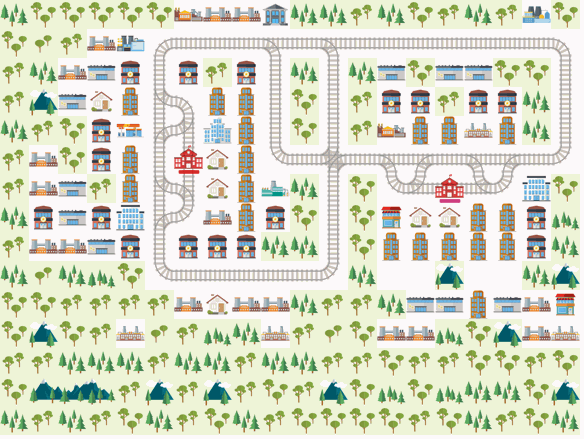

In [102]:
# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=best_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

# Example Render

In [ ]:
# Step loop with video rendering, shortest path policy

obs, info = env.reset()
env_renderer = test_utils.RenderWrapper(env, real_time_render=False, force_gif=True)
env_renderer.render()

while True:
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = 2
    obs, all_rewards, done, _ = env.step(actions)
    env_renderer.render()
    if done['__all__']:
        break

env_renderer.make_gif('test.gif')